# Ray Tune

In [1]:
# Let's import and connect to ray:

import ray
ray.init()
from ray import tune


2021-08-31 00:18:55,000	INFO worker.py:801 -- Connecting to existing Ray cluster at address: 172.31.107.75:6379


In [2]:
# checking ray version
ray.__version__

'1.5.2'

In [3]:
# import PyTorch suite
import torch
import torch.nn as nn

# import Seaborn statistical dataset package
import seaborn as sns
# data processing tools
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
# metrics and 
from sklearn.metrics import max_error
from sklearn.preprocessing import MinMaxScaler
# execution timing, os utils
import time
import os
%matplotlib inline

## We will be using the Flight dataset from Seaborn package for demonstration

In [4]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


## Data Exploration, normally a first step in any ML process


Some Data Processing to make it easier for LSTM

In [5]:
all_data = flight_data['passengers'].values.astype(float)
test_data_size = 12
scaler = MinMaxScaler()
all_data_normalized = scaler.fit_transform(all_data .reshape(-1, 1))
train_data_normalized  = all_data_normalized[:-test_data_size]
test_data_normalized = all_data_normalized[-test_data_size:]
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)


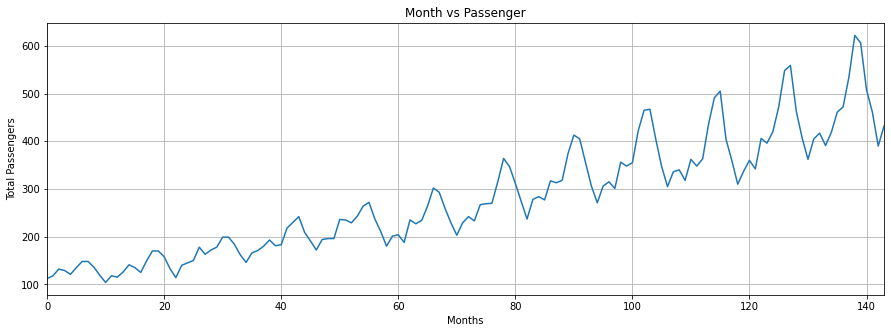

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])


## Some data preparations for LSTM Model

In [7]:
# the passenger value is the input feature, we will be predicting the number of passengers. Need to encode the timeseries in to 12 months windows, normalize values etc.
all_data = flight_data['passengers'].values.astype(float)
test_data_size = 12
scaler = MinMaxScaler()
all_data_normalized = scaler.fit_transform(all_data .reshape(-1, 1))
train_data_normalized  = all_data_normalized[:-test_data_size]
test_data_normalized = all_data_normalized[-test_data_size:]

In [8]:
# timeseries sequence splicing. This can be optimized as a generator function based on input stream.
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)



## With data preparatin and data exploration done, we will start construct the model

In [9]:
# the useal PyToch way -- class based model instantiation, define forward function.
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

### With a model defined, we go into defining the training behavior and testing behavior. In this tutorial, we define a simple trainable, leveraging python Duck Typing.

In [10]:

def train(model, optimizer, loss_function, epochs):
    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        # optional -- you can add fine grain checkpoints here.
        # below is only pseudo code.
#             with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
#                 path = os.path.join(checkpoint_dir, "checkpoint")
#                 torch.save(
#                     (model.state_dict(), optimizer.state_dict()), path)
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
def test(model, test_input, truth):
    model.eval()
    for i in range(train_window):
        seq = torch.FloatTensor(test_input[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
            test_input.append(model(seq).item())
    return max_error(test_input[train_window:],test_data_normalized)


In [11]:
## Orchestrate behaves like a Trainable, taking in a config, then execute the train and test, remit evaluation metrics back to the main train function/actor.
def orchestrate(config):  
    epochs = 50
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    train(model, optimizer, loss_function, epochs)
    test_inputs = train_data_normalized[-train_window:].tolist()
    
    error = test(model, test_inputs, test_data_normalized)
    tune.report(error = error)
    # This saves the model to the trial directory
    torch.save(model.state_dict(), "./model.pth")
    print(error)

In [12]:
## Define the parameter search space, kick off the training.
search_space = {
    "lr":  tune.grid_search([0.1,0.01,0.001,0.0001]),
}

analysis = tune.run(orchestrate, config=search_space)

2021-08-31 00:19:00,877	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,lr
orchestrate_b6dad_00000,PENDING,,0.1
orchestrate_b6dad_00001,PENDING,,0.01
orchestrate_b6dad_00002,PENDING,,0.001
orchestrate_b6dad_00003,PENDING,,0.0001


Result for orchestrate_b6dad_00001:
  date: 2021-08-31_00-19-25
  done: false
  error: 0.36509788036346436
  experiment_id: 1e94d18faddc411fa1aa8f69fbf5c1c9
  hostname: ip-172-31-107-75
  iterations_since_restore: 1
  node_ip: 172.31.107.75
  pid: 127032
  time_since_restore: 21.326329946517944
  time_this_iter_s: 21.326329946517944
  time_total_s: 21.326329946517944
  timestamp: 1630394365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b6dad_00001
  


Trial name,status,loc,lr,iter,total time (s),error
orchestrate_b6dad_00000,RUNNING,,0.1,,,
orchestrate_b6dad_00001,RUNNING,172.31.107.75:127032,0.01,1,21.3263,0.365098
orchestrate_b6dad_00002,RUNNING,,0.001,,,
orchestrate_b6dad_00003,RUNNING,,0.0001,,,


Result for orchestrate_b6dad_00001:
  date: 2021-08-31_00-19-25
  done: true
  error: 0.36509788036346436
  experiment_id: 1e94d18faddc411fa1aa8f69fbf5c1c9
  experiment_tag: 1_lr=0.01
  hostname: ip-172-31-107-75
  iterations_since_restore: 1
  node_ip: 172.31.107.75
  pid: 127032
  time_since_restore: 21.326329946517944
  time_this_iter_s: 21.326329946517944
  time_total_s: 21.326329946517944
  timestamp: 1630394365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b6dad_00001
  
(pid=127032) epoch:  49 loss: 0.0013011860
(pid=127032) 0.36509788036346436
Result for orchestrate_b6dad_00000:
  date: 2021-08-31_00-19-26
  done: false
  error: 0.42706191539764404
  experiment_id: a9c797ba144443189144ca6381d66484
  hostname: ip-172-31-107-75
  iterations_since_restore: 1
  node_ip: 172.31.107.75
  pid: 127031
  time_since_restore: 22.094025373458862
  time_this_iter_s: 22.094025373458862
  time_total_s: 22.094025373458862
  timestamp: 1630394366
  timesteps_since_restore: 0


Trial name,status,loc,lr,iter,total time (s),error
orchestrate_b6dad_00000,TERMINATED,,0.1,1,22.094,0.427062
orchestrate_b6dad_00001,TERMINATED,,0.01,1,21.3263,0.365098
orchestrate_b6dad_00002,TERMINATED,,0.001,1,23.2777,0.556899
orchestrate_b6dad_00003,TERMINATED,,0.0001,1,24.0842,1.10781


2021-08-31 00:19:28,554	INFO tune.py:550 -- Total run time: 27.68 seconds (27.37 seconds for the tuning loop).


(pid=127035) epoch:  49 loss: 0.0037196900
(pid=127035) 1.1078107301793043


### Let's look at the diagram again

### Let's now look at the training result, and analyze the outputs

In [13]:
print("Best config: ", analysis.get_best_config(
    metric="error", mode="min"))


Best config:  {'lr': 0.01}


In [14]:
best_trial = analysis.get_best_trial("error", "min", "last")
print(best_trial)

orchestrate_b6dad_00001


In [15]:
df = analysis.results_df
df.head()

,error,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.lr
trial_id,,,,,,,,,,,,,,,,,,
b6dad_00000,0.427062,22.094025,True,None,None,1,a9c797ba144443189144ca6381d66484,2021-08-31_00-19-26,1630394366,22.094025,127031,ip-172-31-107-75,172.31.107.75,22.094025,0,1,0_lr=0.1,0.1000
b6dad_00001,0.365098,21.326330,True,None,None,1,1e94d18faddc411fa1aa8f69fbf5c1c9,2021-08-31_00-19-25,1630394365,21.326330,127032,ip-172-31-107-75,172.31.107.75,21.326330,0,1,1_lr=0.01,0.0100
b6dad_00002,0.556899,23.277656,True,None,None,1,64985ff41cbf4bb9b6beeaf97e146669,2021-08-31_00-19-27,1630394367,23.277656,127034,ip-172-31-107-75,172.31.107.75,23.277656,0,1,2_lr=0.001,0.0010
b6dad_00003,1.107811,24.084161,True,None,None,1,1421a6f18b224659a6bbd15b3bfebce8,2021-08-31_00-19-28,1630394368,24.084161,127035,ip-172-31-107-75,172.31.107.75,24.084161,0,1,3_lr=0.0001,0.0001


In [16]:
# Depends on whether your model takes in hyper parameters or not.
# the trial specific hyper perameter can be retrieved via below
# best_trial.config["l1"], best_trial.config["l2"]
## Construct the model
best_model = LSTM() 

logdir = best_trial.logdir
state_dict = torch.load(os.path.join(logdir, "model.pth"))
best_model.load_state_dict(state_dict)


<All keys matched successfully>

### Alternatively, if you have enabled checkpointing, you can load more models from checkpoint dir

In [17]:

## construct checkpoint location, load from checkpoint
# checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")
# model_state, optimizer_state = torch.load(checkpoint_path)
# best_trained_model.load_state_dict(model_state)


In [18]:
best_model.eval()
fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        best_model.hidden = (torch.zeros(1, 1, best_model.hidden_layer_size),
                        torch.zeros(1, 1, best_model.hidden_layer_size))
        test_inputs.append(best_model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

print(actual_predictions)

[[492.26158166]
 [555.72547495]
 [513.9561069 ]
 [434.85827518]
 [360.69448662]
 [361.38732624]
 [435.76270258]
 [526.86339414]
 [558.13460553]
 [478.42374659]
 [396.94358397]
 [334.63568926]]


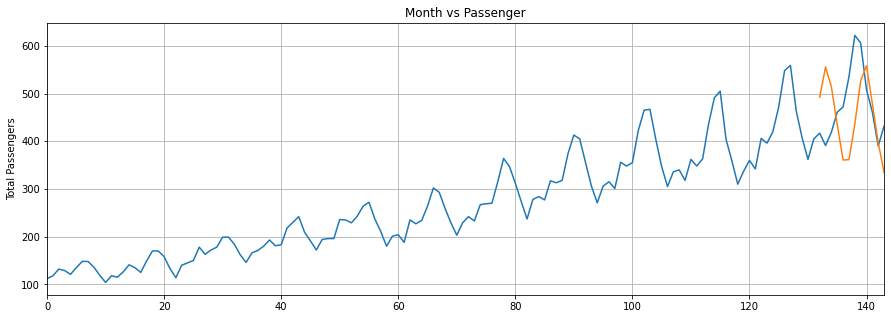

In [19]:
x = np.arange(132, 144, 1)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

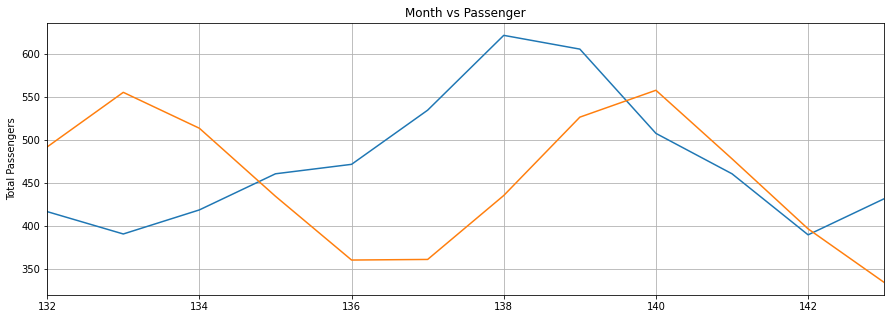

In [20]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()